In [2]:
import numpy  as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite as bi
import matplotlib.pyplot as plt
from datetime import datetime
from imp import reload 
import os
from tqdm import tqdm
from scipy import stats as st


import  weighted_network as wn
import dataset_construction as dc

import seaborn as sns
import bipcm

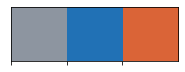

In [3]:
colours=['#8D95A0','#2171b5','#DA6437']
own=sns.color_palette(colours)

sns.palplot(own)
sns.set_palette(own)

# This notebook provides the codes for the figures and tables in the main paper and the appendix

## Figures

### Figure 1: Cumulative frequency of treaties for different subjects in 2015

In [ ]:
df_subjects=pd.read_csv('IEA_data/subject_cat.csv')
df_treaty_subjects=pd.read_csv('IEA_data/subject_rel.csv')
df_parties_total=pd.read_csv("IEA_data/parties.csv",sep=",")

list_TypeofDates=['date_entry_into_force','date_ratification','date_simple_sigNMture','date_definite_sigNMture','date_withdrawal','date_consent_to_be_bound','date_accession_approv','date_acceptance_approv','date_provisioNMl_application','date_succession','date_reservation']
for i in list_TypeofDates:
    df_parties_total[i]=pd.to_datetime(df_parties_total[i],format='%d/%m/%Y')
df_parties_1=df_parties_total[(df_parties_total['date_entry_into_force']<datetime(1947,12,31))|(df_parties_total['date_ratification']<datetime(1947,12,31))]

old_treaties=set(df_parties_1['treaty_id'])
for i in old_treaties:
    df_parties_total=df_parties_total[df_parties_total['treaty_id']!=i]


df_notnull=df_parties_total[df_parties_total['date_ratification'].notnull()|df_parties_total['date_entry_into_force'].notnull()]
set_notnull=set(df_notnull['treaty_id'])

treaties=list(set(list(df_notnull['treaty_id'])))
df_treaties=pd.DataFrame(treaties,columns=['treaty_id'])
df_parties_1=pd.merge(df_treaties,df_treaty_subjects,left_on='treaty_id',right_on='treaty_id',how='left')

# get the distribution of the subjects
subject_distribution_notnull={}
for i in df_subjects['id']:
    key=list(df_subjects[df_subjects['id']==i]['subject'])[0]
    subject_distribution_notnull[key]=len(df_parties_1[df_parties_1['subject_id']==i])
    
subject_distribution_ordered_notnull=dict(sorted(subject_distribution_notnull.items(), key=lambda d: d[1]))

In [ ]:
sub_y=list(subject_distribution_ordered_notnull.keys())
sub_x=list(subject_distribution_ordered_notnull.values())
num_type=np.arange(len(sub_y))

x_lim=[0,180]


figsize = 12,9
figure, ax = plt.subplots(figsize=figsize)

font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 24,
    }

plt.barh(num_type, sub_x, color=colours[1],tick_label=sub_y,height=0.5)


ax.set_xlim(x_lim)

plt.xticks(np.arange(0, 176, step=25))

plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 

plt.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True) 


font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 32,
    }

plt.xlabel('Number of treaties',font2)
plt.ylabel("Subjects of treaties",font2)

plt.grid(axis='x',linestyle='--', linewidth=1.2,color="black", alpha=0.3)

plt.subplots_adjust(left=0.34) 


plt.savefig("results/TreatySubjectsOrdered_new.pdf", bbox_inches='tight')

### Figures 3-7： Cumulative frequency of nodes, Cumulative frequency of links, Average degree, Average strength, Cumulative density, Average weighted shortest distance, Global clustering coefficient from 1971 to 2015

In [ ]:
df_country=pd.read_csv('results/global_measures_country_network.csv')
df_UN=pd.read_csv('results/global_measures_country_network_UN.csv')
df_UNagency=pd.read_csv('results/gloabl_measures_country_without_UN&Agencies.csv')

In [ ]:
def plot_global_measures(x1,x2,x3,y1,y2,y3,x_lim,y_lim,x_label,y_label,loc,file_name):
   

    figsize = 12,9
    figure, ax = plt.subplots(figsize=figsize)

    
    A,=plt.plot(x1,y1,c=colours[1],label='All treaites',linewidth=4)
    C,=plt.plot(x2,y2,color=colours[0],label='Excluding UN treaties',linewidth=4, linestyle='--', alpha=0.9)
    D,=plt.plot(x3,y3,c=colours[0],label='Excluding UN & UN agency treaties',linewidth=4, linestyle=':',alpha=0.9)
    
    
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 22,
    }
    
    legend = plt.legend(handles=[A,C,D],prop=font1,loc=loc,facecolor=None )
    legend.get_frame().set_linewidth(0.0)

    ax.spines['top'].set_visible(False) #去掉上边框
    ax.spines['right'].set_visible(False) #去掉左边框
    ax.spines['left'].set_visible(False) #去掉右边框
    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    
    
    plt.yticks(fontsize=25)    
    plt.xticks(fontsize=25)  
    

    plt.grid(axis='y',linestyle='--', linewidth=1.2,color="black", alpha=0.3)

        
    plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True) 
    
    
    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 32,
    }
    plt.xlabel(x_label,font2)
    plt.ylabel(y_label,font2)
    

    file_name='results/'+file_name+'.pdf'
    plt.savefig(file_name)



In [ ]:
aa='number_of_nodes'
bb='number_of_links'
cc='density'
dd='number_of_components'
ee='fraction_of_largest_component'
ff='average_degree'
gg='average_strength'
hh='average_weighted_shortest_path_length'
jj='weighted_global_clustering_coefficient'

In [ ]:
a='Cumulative frequency of nodes'
b='Cumulative frequency of links'
c='Cumulative density'
d='Cumulative frequency of components'
e='Fraction of the largest component'
f='Average degree'
g='Average strength'
h='Average weighted shortest distance'
j='Weighted global clustering coefficient'

In [ ]:
measure=cc
plot_global_measures(df_country['year'],df_UN['year'],df_UNagency['year'], df_country[measure],df_UN[measure],df_UNagency[measure],
         [1965,2020],[0.,1.01],'Year',c,'lower right','density')


In [ ]:
measure='ratio'
plot_global_measures(df1['year'],df2['year'],df3['year'],df1['year'], df1[measure],df2[measure],df3[measure],df1[measure],
         [1965,2020],[0.,1],'Year','Proportion of countries','lower right','NodesRatio_Robu_Agency')
